# Ford GoBike System Data
## by Kyung Nam Kim

## Preliminary Wrangling

> Ford GoBike System is a the Bay Area's bike share system. Bike share system allow users to rent bicycles for short trips, typically 30 minutes or less.In this project, I will perform an exploratory analysis on data provided by Ford GoBike.

In [1]:
# import all packages and set plots to be embedded inline
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
%matplotlib inline

In [2]:
# download the dataset with pandas
csv_folder = 'trip_data_files'

In [3]:
makedirs(csv_folder)
pd.read_csv('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv').to_csv('{}/2017-forgobike-tripdata.csv'.format(csv_folder))
for month in range(1,13):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2018' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder trip_data_files
    unzipped_file.extractall(csv_folder)

In [4]:
# Combine All Locally Saved CSVs into One DataFrame
list_csvs = []
for file_name in listdir(csv_folder):
    list_csvs.append(pd.read_csv(csv_folder+'/'+file_name))
df = pd.concat(list_csvs)

In [5]:
df.to_csv('data.csv', index = False)

In [6]:
# Examine DataFrame
df = pd.read_csv('data.csv')

In [7]:
len(df)

2383421

In [8]:
#Set visualization style
sns.set_style('whitegrid')
sns.set_context("talk")

In [9]:
#Make column to easily notify member's age
df['member_age'] = 2019-df['member_birth_year']

In [10]:
# Check age distrubition
df['member_age'].describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .75, .8, .9, .95])

count    2.206162e+06
mean     3.646318e+01
std      1.051346e+01
min      1.900000e+01
10%      2.500000e+01
20%      2.800000e+01
30%      3.000000e+01
40%      3.200000e+01
50%      3.400000e+01
60%      3.700000e+01
70%      4.000000e+01
75%      4.200000e+01
80%      4.500000e+01
90%      5.200000e+01
95%      5.700000e+01
max      1.380000e+02
Name: member_age, dtype: float64

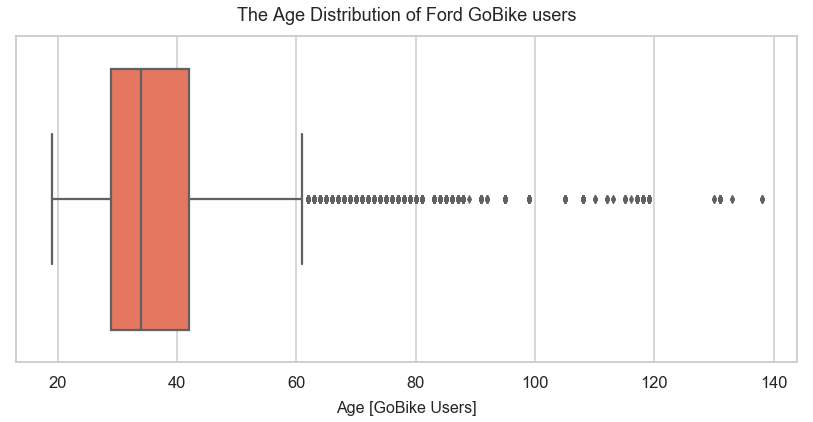

In [11]:
plt.figure(figsize=(14,6))
sns.boxplot(x='member_age', data=df, palette='Reds', orient='h')
plt.title("The Age Distribution of Ford GoBike users", fontsize=18, y=1.03)
plt.xlabel("Age [GoBike Users]", fontsize=16, labelpad=10)
plt.savefig('image01.png');

Ages from 19 to 57 takes 95% of the users. There were users more than 100 years old. So, I will remove users older than 60 for better observaitons here.

In [12]:
df = df[df['member_age']<=60]

In [13]:
df['member_age'].mean()

35.589358772106486

Ford bike users' average user age is around 35~36.

In [14]:
df.drop(['Unnamed: 0', 'member_birth_year'], axis=1, inplace=True)

In [15]:
df.head(2)

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_gender,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,user_type,member_age
0,96,NaN,80110,43.0,37.778768,-122.415929,San Francisco Public Library (Grove St at Hyde...,2018-01-01 15:12:50.2450,Male,74.0,37.776435,-122.426244,Laguna St at Hayes St,2017-12-31 16:57:39.6540,Customer,32.0
1,88,NaN,78800,96.0,37.766210,-122.426614,Dolores St at 15th St,2018-01-01 13:49:55.6170,Female,284.0,37.784872,-122.400876,Yerba Buena Center for the Arts (Howard St at ...,2017-12-31 15:56:34.8420,Customer,54.0


Ford GoBike spreaded the service to Bay Area including San Francisco, Oakland and San Jose. However, I decided to focus on San Fancisco area to remove complexity.

In [16]:
#Filter data only to include San Francisco rides
max_longitude_sf = -122.3597
min_longitude_sf = -122.5147
max_latitude_sf = 37.8121
min_latitude_sf = 37.7092

In [17]:
end_station_latitude_mask = (df['end_station_latitude']>=min_latitude_sf) & (df['end_station_latitude']<=max_latitude_sf)
start_station_latitude_mask = (df['start_station_latitude']>=min_latitude_sf) & (df['start_station_latitude']<=max_latitude_sf)

In [18]:
end_station_longitude_mask =(df['end_station_longitude']>=min_longitude_sf) & (df['end_station_longitude']<=max_longitude_sf)
start_station_longitude_mask = (df['start_station_longitude']>=min_longitude_sf) & (df['start_station_longitude']<=max_longitude_sf)

In [19]:
df = df[end_station_latitude_mask & start_station_latitude_mask & end_station_longitude_mask & start_station_longitude_mask]

In [20]:
len(df)

1588191

Now the data size became around 1.6millions.

In [21]:
# high-level overview of data shape and composition
print(df.shape)
print(df.dtypes)
print(df.head())

(1588191, 16)
bike_id                      int64
bike_share_for_all_trip     object
duration_sec                 int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name            object
end_time                    object
member_gender               object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name          object
start_time                  object
user_type                   object
member_age                 float64
dtype: object
    bike_id bike_share_for_all_trip  duration_sec  end_station_id  \
0        96                     NaN         80110            43.0   
1        88                     NaN         78800            96.0   
12     2311                     NaN          2183            24.0   
13     3717                     NaN          2170            24.0   
15      558                     NaN          1544            27.0  

### What is the structure of your dataset?

> There are 1588191 data entries and 16 columns including start/end_station_ids, duration_sec, bike_id, and etc.

### What is/are the main feature(s) of interest in your dataset?

> I'm interested in features that explain user behavior and personal details:
Average riding distance
Average riding duration
Age groups of users(I will create this one)
Genders
Weekly day distribution etc. in the dataset.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I assume age group and the weekly day distribution will help support my investigation.

## Univariate Exploration

In [22]:
#Generate new fields for date from start_time and end_time
df['start_time']=pd.to_datetime(df['start_time'])
df['end_time']=pd.to_datetime(df['end_time'])

In [23]:
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date

In [24]:
df['start_time_year_month']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year_month']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))

In [25]:
df['start_time_year_month_renamed'] = df['start_time'].dt.strftime('%y' + '-' + '%m')

In [26]:
df['start_time_year']=df['start_time'].dt.year.astype(int)
df['end_time_year']=df['end_time'].dt.year.astype(int)

In [27]:
df['start_time_month']=df['start_time'].dt.month.astype(int)
df['end_time_month']=df['end_time'].dt.month.astype(int)

In [28]:
df['start_time_hour_minute']=df['start_time'].map(lambda x: x.strftime('%H-%m'))
df['end_time_hour_minute']=df['end_time'].map(lambda x: x.strftime('%H-%m'))

In [29]:
df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour

In [30]:
df['start_time_weekday']=df['start_time'].dt.weekday_name
df['end_time_weekday']=df['end_time'].dt.weekday_name

In [31]:
df['start_time_weekday_abbr']=df['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df['end_time_weekday_abbr']=df['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [32]:
#Generate a new field for member age group
df['member_age_group'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else x)

In [33]:
#Generate minutes for trip duration from duration_sec
df['duration_min'] = df['duration_sec']/60

In [34]:
#Generate new fields for distance
def distance(origin, destination):
    """
    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [35]:
df['distance_km_estimates'] = df.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)

## Question 1. How is Ford GoBike growing?

### Change in daily count of rides

In [36]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

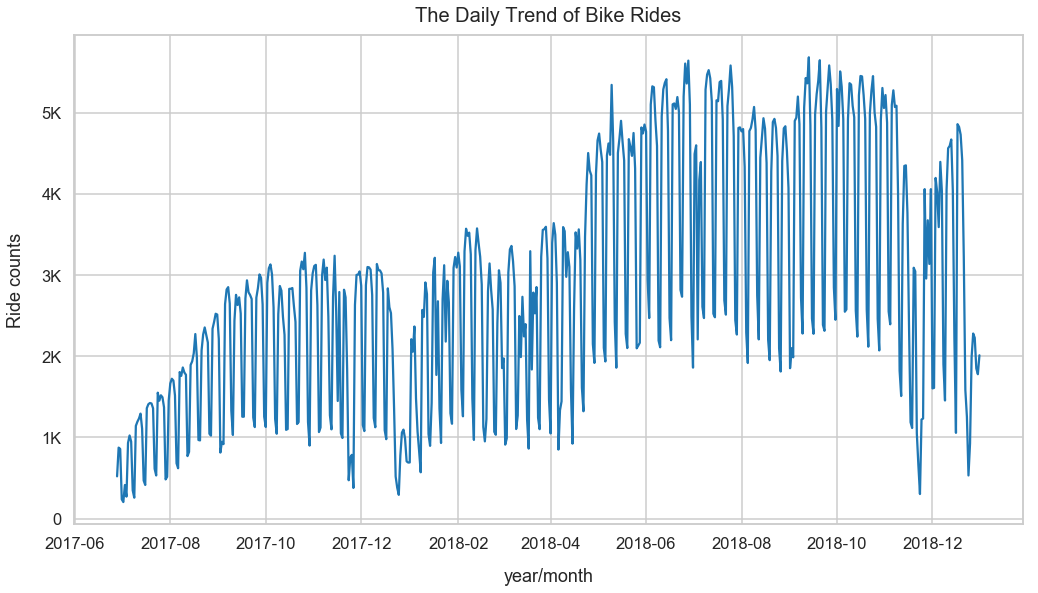

In [37]:
df.groupby('start_time_date').agg({'bike_id':'count'}).plot(style='-', legend=False, figsize=(17,9))
plt.title('The Daily Trend of Bike Rides', fontsize=20, y=1.015)
plt.xlabel('year/month', labelpad=16)
plt.ylabel('Ride counts', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image02.png');

Compared to beginning of July 2017, where daily rides were less than 1K, it increased to more than 5K after less than year (June 2018) There is huge decrease around January 2018 and December 2018. I can't say the exact reason, but it seems that cold weather causes less number of rides.

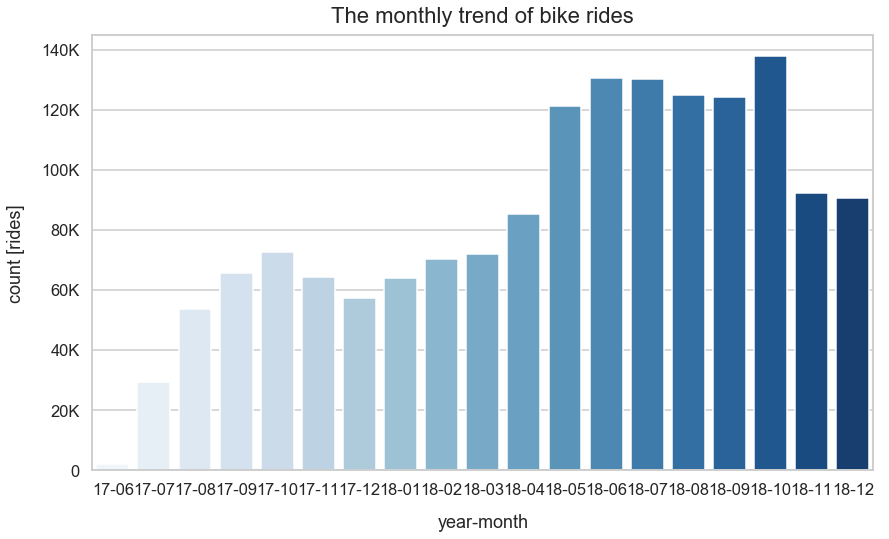

In [38]:
plt.figure(figsize=(14,8))
sns.countplot(x='start_time_year_month_renamed', palette="Blues", data=df.sort_values(by='start_time_year_month_renamed'))
plt.title('The monthly trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))

There is seasonality when the season is winter because it is cold. 
However, bike rides of July 2017 and 2018 increased more than 5 times.

### Riders by Age Group Per Month

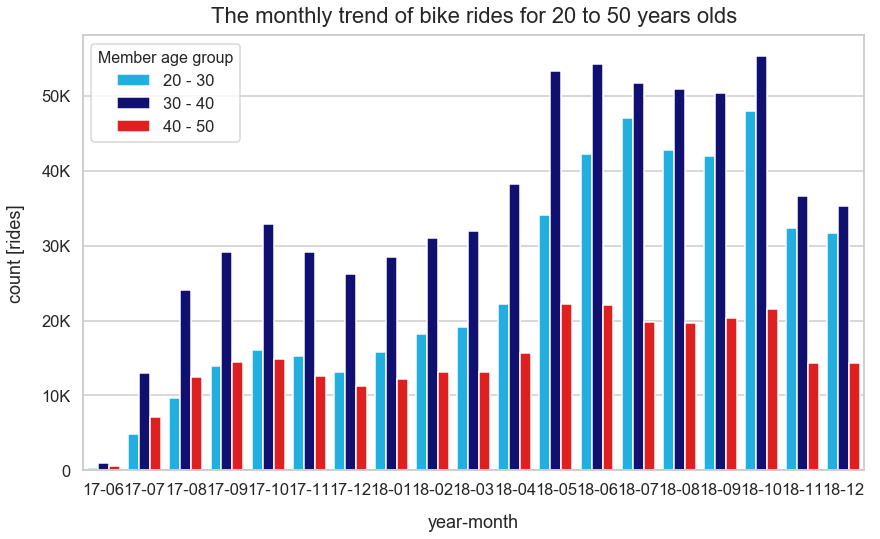

In [39]:
plt.figure(figsize=(14,8))
my_palette = {'20 - 30': 'deepskyblue', '30 - 40': 'navy', '40 - 50': 'red'}
ax = sns.countplot(x='start_time_year_month_renamed', hue='member_age_group', palette=my_palette, data=df[df['member_age_group'].isin(['20 - 30', '30 - 40', '40 - 50'])].sort_values(by=['start_time_year_month_renamed', 'member_age_group']))
plt.title('The monthly trend of bike rides for 20 to 50 years olds', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image04.png');

In general, people in 30-40s rode bike the most. People in 40-50s rode the bikes the least. Also, both 20-30s and 30-40s increased a lot while 40-50s showed mediocre increase.

## Question 2. How does rides trend change per age, gender, weekday, and hour of a day?

### Total rides

In [40]:
df['bike_id'].count()

1588191

There were 1588191 rides.

### Distrubition of bike rides vs user age group

In [41]:
trip_by_age_df = df.groupby('member_age_group').agg({'bike_id':'count'})

In [42]:
trip_by_age_df['perc'] = (trip_by_age_df['bike_id']/trip_by_age_df['bike_id'].sum())*100

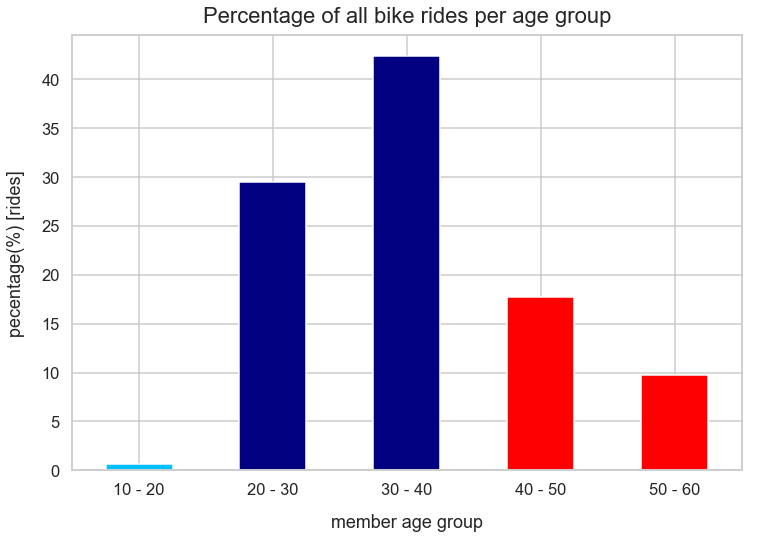

In [43]:
new_color = ['deepskyblue', 'navy', 'navy', 'red', 'red']
trip_by_age_df['perc'].plot(kind='bar', color=new_color, figsize=(12,8))
plt.title('Percentage of all bike rides per age group', fontsize=22, y=1.015)
plt.xlabel('member age group', labelpad=16)
plt.ylabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image05.png');

20 to 40 years old people took the more than 70% of bike rides. 
Among those, 30 to 40 years old people's rides account more than 40%of all bike rides.
10 to 20 years old people took the least rides, but this happens because the data only include people who are older than 18.

### Bike rides per gender

In [44]:
trip_by_gender_df = df.groupby('member_gender').agg({'bike_id':'count'})

In [45]:
trip_by_gender_df['perc'] = (trip_by_gender_df['bike_id']/trip_by_gender_df['bike_id'].sum())*100

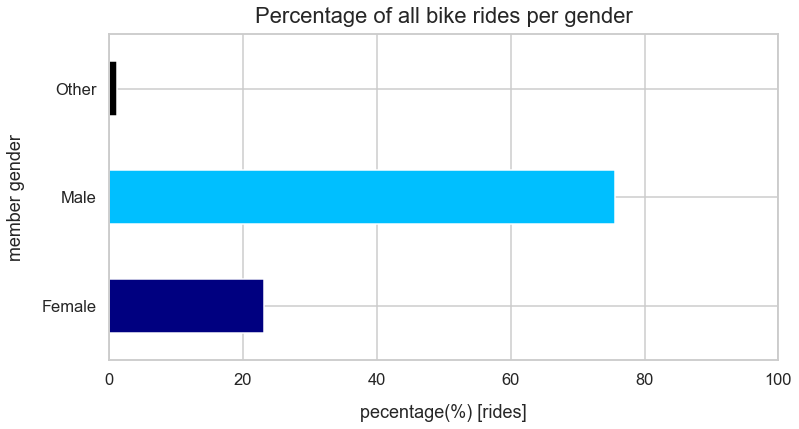

In [46]:
new_color = ['navy', 'deepskyblue', 'black']
trip_by_gender_df['perc'].plot(kind='barh', color=new_color, figsize=(12,6))
plt.title('Percentage of all bike rides per gender', fontsize=22, y=1.015)
plt.ylabel('member gender', labelpad=16)
plt.xlabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.xlim(0,100)
plt.savefig('image06.png');

Males took almost 80% of rides while femalse barely took more than 20% of rides.

### Bike rides per weekday

In [47]:
trip_by_weekday_df = df.groupby('start_time_weekday_abbr').agg({'bike_id':'count'})

In [48]:
trip_by_weekday_df['perc'] = (trip_by_weekday_df['bike_id']/trip_by_weekday_df['bike_id'].sum())*100

In [49]:
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

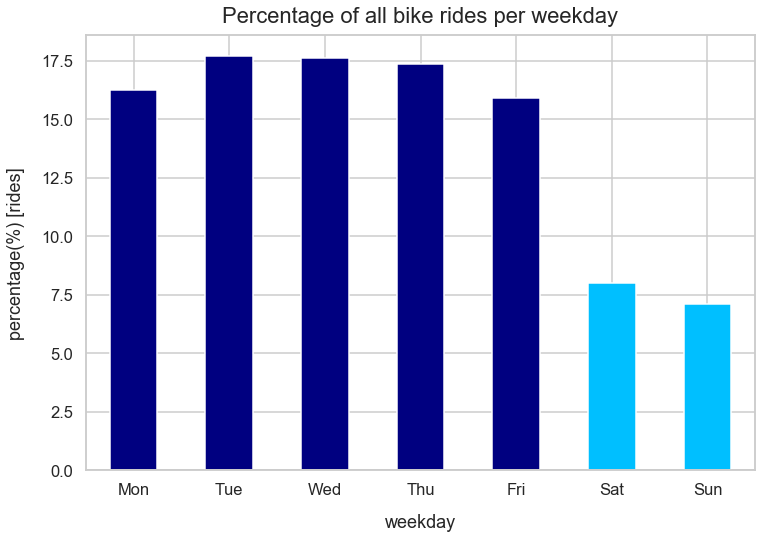

In [50]:
new_color = ['navy', 'navy', 'navy', 'navy', 'navy', 'deepskyblue', 'deepskyblue']
trip_by_weekday_df.reindex(weekday_index)['perc'].plot(kind='bar', color=new_color, figsize=(12,8), legend=False)
plt.title('Percentage of all bike rides per weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image07.png');

People use this service on weekdays more than weekends.

### Peak hours of the day

In [51]:
trip_by_hour_df = df.groupby('start_time_hour').agg({'bike_id':'count'}).reset_index()

In [52]:
trip_by_hour_df['bike_id'] = (trip_by_hour_df['bike_id']/trip_by_hour_df['bike_id'].sum())*100

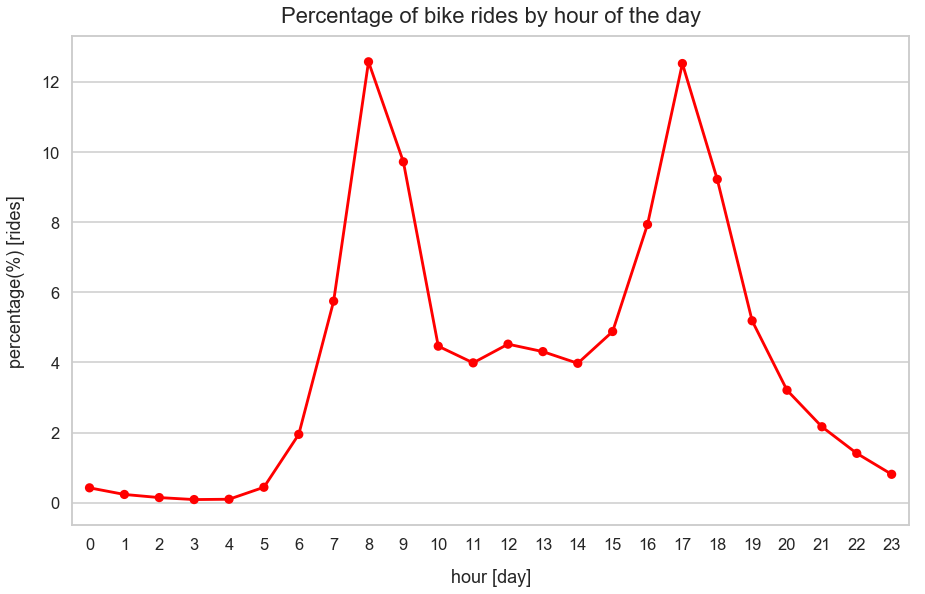

In [53]:
plt.figure(figsize=(15,9))
sns.pointplot(x='start_time_hour', y='bike_id', scale=.7, color='red', data=trip_by_hour_df)
plt.title('Percentage of bike rides by hour of the day', fontsize=22, y=1.015)
plt.xlabel('hour [day]', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.savefig('image08.png');

The peak hours are 8 am and 5 pm, which are common rush hours. Also, there are some usages during lunch time.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> All these variables that I checked (Daily and monthly trend of riders, age groups, genders, weekdays or weekends comparision, peak hours, etc.)  are important in order to understand the dataset.
20-40 years old users increased rapidly. 
20 to 40 years old people took the more than 70% of bike rides. Among those, 30 to 40 years old people's rides account more than 40% of all bike rides.  
Male took around %76 of all bike rides, and female took around %24 of them.  
People use this service on weekdays more than weekends.  
8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well.  

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I removed the data which contains member ages more than 60 years old since people over 60 years old only consist 5% of the riders.  
I generated new fields such as duration, time, age groups etc. in order to calculate them easily and understand the dataframe.  
Ford GoBike spreaded the service to San Francisco, Oakland and San Jose. However, it's hard to imagine traffic, so I decided to focus on San Fancisco area by limiting with latitude and longitude. 

## Bivariate Exploration


## Question 3. Are there any difference between subscribers' and customers' behaviors?

### Percentage of bike rides of subscribers vs customers

In [54]:
count_of_rides_per_user_type = df.groupby('user_type').size().reset_index(name='count')

In [55]:
count_of_rides_per_user_type['count']/len(df)*100

0    11.888998
1    88.111002
Name: count, dtype: float64

Percentage of subscribers is almost 88.11%.  
Percentage of customers is almost 11.88%.


### User trends of bike rides of subscribers vs customers

In [56]:
user_type_count_per_year_df = df.groupby(["start_time_year_month_renamed", "user_type"]).size().reset_index()

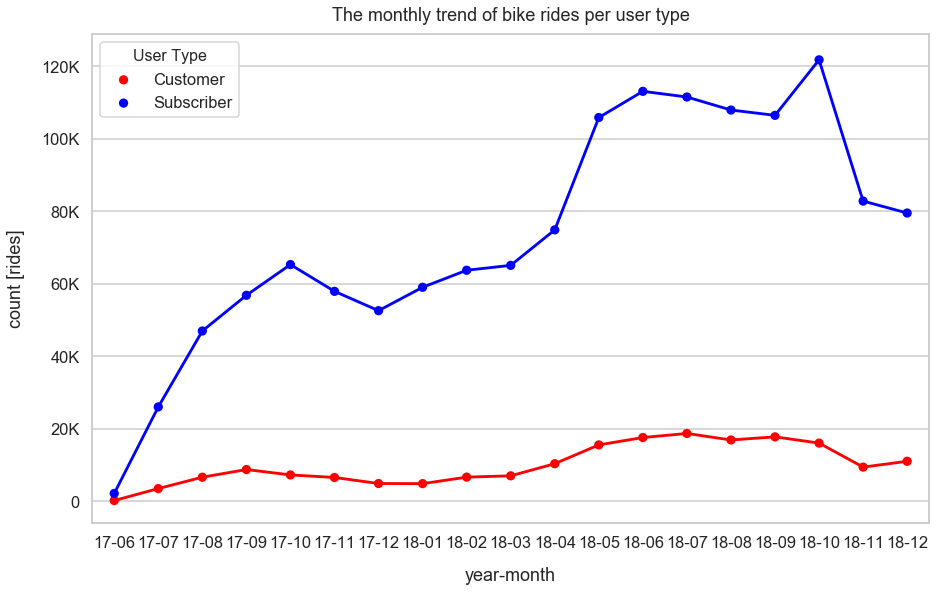

In [57]:
plt.figure(figsize=(15,9))
my_palette = {'Subscriber':'blue', 'Customer':'red'}
ax = sns.pointplot(x='start_time_year_month_renamed', y=0, hue='user_type', palette=my_palette, scale=.7, data=user_type_count_per_year_df)
plt.title('The monthly trend of bike rides per user type', fontsize=18, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image09.png');

Both subscribers and customers increased but subscribers increased more rapidly. While customers showed little change, subscribers showed some up and down during the period.

### Average trip duration of subscribers vs customers

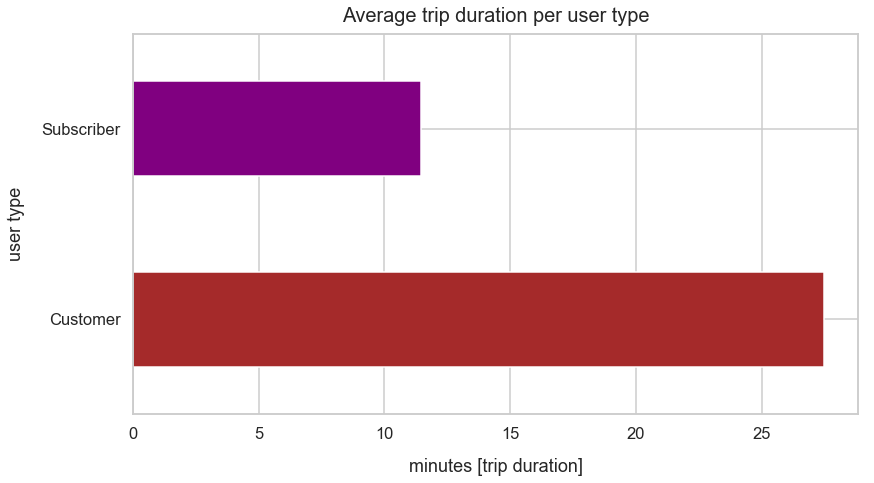

In [58]:
new_color=['brown', 'purple']
ax = df.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip duration per user type', fontsize=20, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('minutes [trip duration]', labelpad=16);

Subscribers' average trip duration is around 11 minutes.  
Customers' average trip duration is around 28 minutes.  

### Average trip distance of subscribers vs customers

Text(0.5,0,'km [distance]')

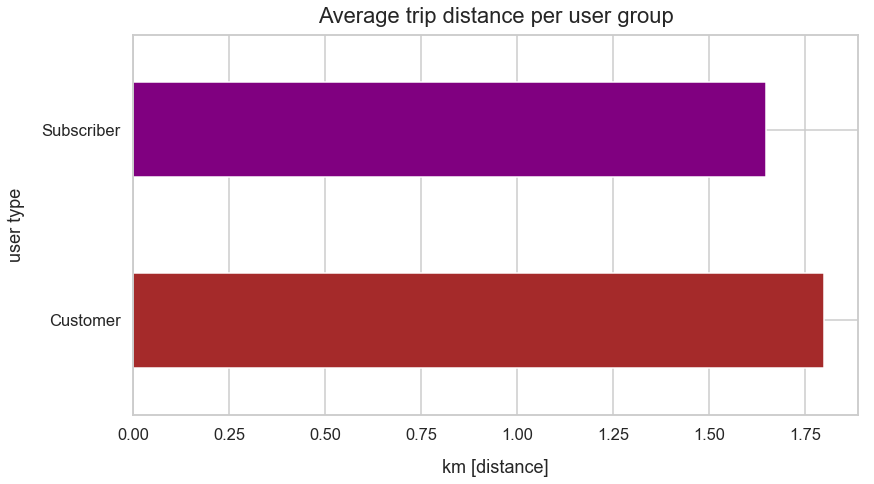

In [59]:
ax = df.groupby('user_type')['distance_km_estimates'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average trip distance per user group', fontsize=22, y=1.015)
ax.set_ylabel('user type', labelpad=16)
ax.set_xlabel('km [distance]', labelpad=16)

Both subscribers and customers have similar average trip distance which is around 1.6km(1mile).

### The trend of subscriber rides per age group

In [60]:
subscriber_age_df = df[df['user_type']=='Subscriber'].groupby(['start_time_year_month_renamed', 'member_age_group']).agg({'bike_id':'count'}).reset_index()

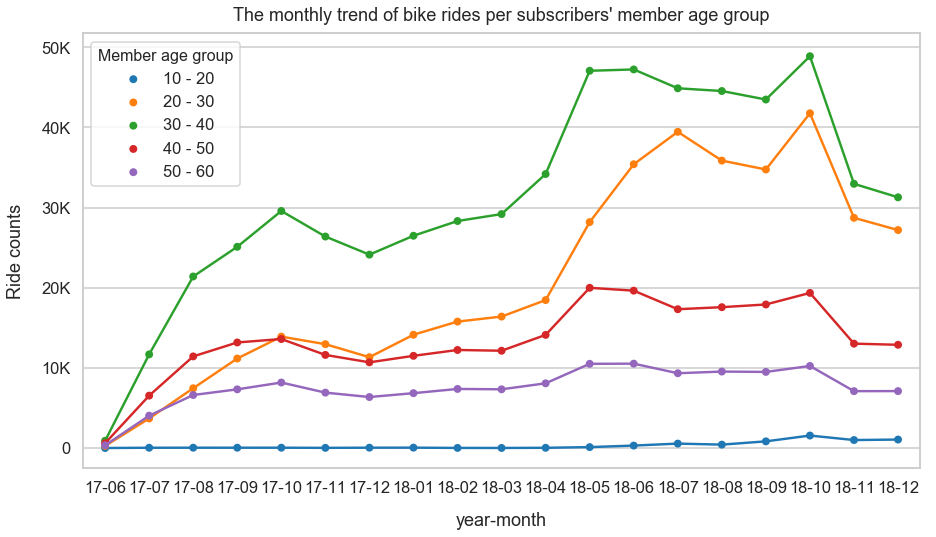

In [61]:
plt.figure(figsize=(15,8))
ax = sns.pointplot(x='start_time_year_month_renamed', y='bike_id', hue='member_age_group', scale=.6, data=subscriber_age_df)
plt.title("The monthly trend of bike rides per subscribers' member age group", fontsize=18, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('Ride counts', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image10.png');

In general, age groups show similar trend in change of ride counts. They increase during spring and summer while decrease in late fall- winter.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Percentage of subscribers is almost 88.11%. Percentage of customers is almost 11.88%.  
Subscribers' average trip duration is around 11 minutes. Customers' average trip duration is around 28 minutes.  
Subscribers and customers trip distance were about the same, which is slightly more than one mile.  
Among subscribers, people in 30-40 years old ride the most, 20-30 are in second place. At the start of service, people in 40-50 rode more than those in 20-30 but soon 20-30 surpassed people in 40-50.In general, number of rides by subscribers in each age group increase during warm period and decrease in winter.


## Multivariate Exploration


I want to explore in this part of the analysis is how the three variables (Age group, weekdays, timeframe of subscribers) in relationship with hiring. Because, subscribers are more common and hiring partners of this program.

In [73]:
subscriber_hour_df2 = df[(df['member_age']>=20) & (df['member_age']<30) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [74]:
subscriber_hour_df3 = df[(df['member_age']>=30) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [75]:
subscriber_hour_df4 = df[(df['member_age']>=40) & (df['member_age']<50) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [76]:
subscriber_hour_df2['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df2['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [77]:
subscriber_hour_df3['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df3['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [78]:
subscriber_hour_df4['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df4['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [79]:
subscriber_hour_df2['count_perc'] = subscriber_hour_df2['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [80]:
subscriber_hour_df3['count_perc'] = subscriber_hour_df3['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [81]:
subscriber_hour_df4['count_perc'] = subscriber_hour_df4['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [82]:
subscriber_hour_df2['rank'] = subscriber_hour_df2['count_perc'].rank(ascending=False).astype(int)

In [83]:
subscriber_hour_df3['rank'] = subscriber_hour_df3['count_perc'].rank(ascending=False).astype(int)

In [84]:
subscriber_hour_df4['rank'] = subscriber_hour_df4['count_perc'].rank(ascending=False).astype(int)

In [85]:
subscriber_hour_df_pivoted2 = subscriber_hour_df2.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

In [86]:
subscriber_hour_df_pivoted3 = subscriber_hour_df3.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

In [87]:
subscriber_hour_df_pivoted4 = subscriber_hour_df4.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

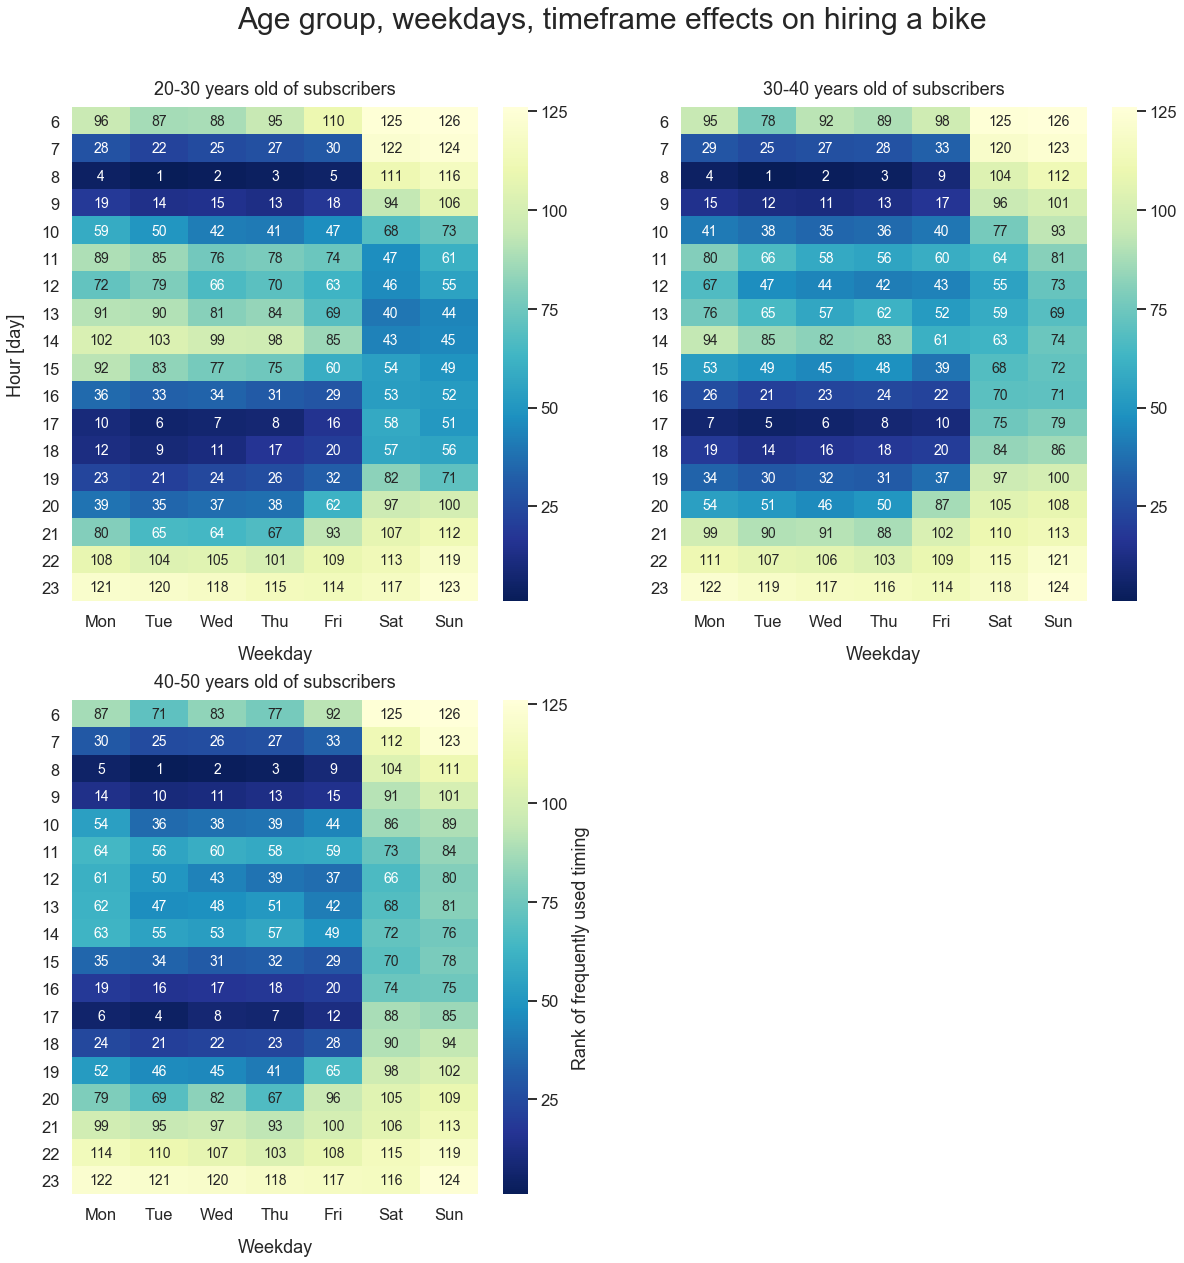

In [88]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.suptitle('Age group, weekdays, timeframe effects on hiring a bike', fontsize=30, y=0.95)
sns.heatmap(subscriber_hour_df_pivoted2, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 14})
plt.title("20-30 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour [day]', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(222)
sns.heatmap(subscriber_hour_df_pivoted3, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 14})
plt.title("30-40 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.subplot(223)
sns.heatmap(subscriber_hour_df_pivoted4, fmt='d', annot=True, cmap='YlGnBu_r', annot_kws={"size": 14}, cbar_kws={'label': 'Rank of frequently used timing'})
plt.title("40-50 years old of subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.savefig('image11.png');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> I extended my investigation of bike hiring with 3 different variables such as age group, timeframe, weekday. The multivariate exploration here showed me that people who are older than the others have more time to drive a bike rather than a young people. 
20-30 years old people are active when people are commuting. These figures shows us when people become older, they ride these bikes everytime in a day like in the lunch time or in the morning or in the afternoon. 
It may be related with their retirement or older people have much more flexiable working hours rather than youngers. 

### Were there any interesting or surprising interactions between features?

> I was expecting to see much less hiring quantities in a day but these figures show that they are active and they are flexible than youngers.

## Conclusion

> There were 1.6 million rides.
In general, people in 30-40s rode bike the most. People in 40-50s rode the bikes the least. Also, both 20-30s and 30-40s increased a lot while 40-50s showed mediocre increase.
20 to 40 years old people took the more than 70% of bike rides. Among those, 30 to 40 years old people's rides account more than 40%of all bike rides. 
Male took around 76% of all bike rides, and female took around 24% of them.
People use this service on weekdays more than weekends.
8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well.
Percentage of subscribers is almost %88.15. Percentage of customers is almost %11.85.
Customers' rides seems increasing slightly but subscibers' rides reached 6 times more than customers' on October 2018. There is a decrease on November 2018 for subscribers but it seems like it is related with winter season.
Subscribers' average trip duration is around 11 minutes. Customers' average trip duration is around 28 minutes.
Subscribers and customers trip distance were about the same, which is slightly more than one mile.
90% of bike rides take place on weekday.
The peak bike rides time for all members is around commute time.
